In [1]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact,pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
import plotly.express as px
import shap
from joblib import dump
from joblib import load
%config IPCompleter.greedy=True

In [2]:
plt.rcParams['figure.dpi'] = 72
df1 = pd.read_csv('vehicles_trimmed1.csv')
df2 = df1
df2['price'] = df2['price'].replace(0,np.NaN)
df2 = df2.dropna(subset=['price'])
df2 = df2[(df2['price'] >= np.percentile(df2['price'], 0.05)) &
          (df2['price'] <= np.percentile(df2['price'], 99.95))]
train_orig, test = train_test_split(df2.drop(columns=['county','Unnamed: 0']) , test_size = 0.1, train_size = 0.9)
train, val = train_test_split(train_orig, train_size = 0.9, test_size = 0.1)
train

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,image_url,state,lat,long
1541,7045940311,vermont,18995.0,2016.0,honda,cr-v,like new,4 cylinders,gas,25843.0,clean,automatic,4wd,NaN,SUV,brown,https://images.craigslist.org/00o0o_aDTl81PZ4q...,vt,43.5125,-71.4958
265421,7043311430,frederick,5495.0,2004.0,honda,cr-v,good,4 cylinders,gas,157000.0,clean,automatic,4wd,mid-size,SUV,silver,https://images.craigslist.org/00o0o_358gBQvfEu...,md,39.5642,-76.9807
11478,7049545856,richmond,5400.0,2013.0,ford,fusion se,excellent,4 cylinders,gas,172000.0,clean,automatic,fwd,full-size,sedan,silver,https://images.craigslist.org/01515_iJuPem8i5b...,va,37.4310,-77.6545
281431,7048412669,flint,3495.0,2009.0,volkswagen,NaN,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,https://images.craigslist.org/00Y0Y_8yS7kBfBoQ...,mi,43.1824,-84.1122
498520,7037768119,lubbock,7000.0,2013.0,ford,f-150,excellent,6 cylinders,gas,235600.0,clean,automatic,rwd,NaN,NaN,white,https://images.craigslist.org/00L0L_gJRV4DQtXm...,tx,33.5637,-101.9010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239906,7048401912,waterloo / cedar falls,5400.0,2009.0,pontiac,vibe,excellent,4 cylinders,gas,109000.0,clean,automatic,fwd,compact,sedan,NaN,https://images.craigslist.org/00k0k_bjScFFwbgb...,ia,42.4845,-92.3250
200479,7049893355,boise,4995.0,2002.0,ford,escape,NaN,NaN,gas,116128.0,clean,automatic,4wd,NaN,SUV,blue,https://images.craigslist.org/00e0e_1qEOiTGPX3...,id,43.8625,-116.5000
26717,7049759847,seattle-tacoma,18400.0,2018.0,chevrolet,express 2500,like new,6 cylinders,gas,14200.0,rebuilt,automatic,rwd,full-size,van,white,https://images.craigslist.org/01414_8Ec789YAFL...,wa,45.4570,-122.5780
110507,7049829008,sacramento,8900.0,1994.0,toyota,pickup truck,NaN,NaN,gas,NaN,clean,manual,NaN,NaN,NaN,NaN,https://images.craigslist.org/00v0v_orRQdEMooZ...,ca,38.7195,-120.8050


In [3]:
## Final model for app usage

target = 'price'
features1 = ['year', 'manufacturer', 'cylinders','fuel', 'odometer']
X_train1 = train[features1]
y_train = train[target]
X_val1 = val[features1]
y_val = val[target]
X_test1 = test[features1]
y_test = test[target]

In [4]:
# pipeline1 = make_pipeline(
#     ce.TargetEncoder(),
#     SimpleImputer(strategy='median'),
#     RandomForestRegressor(max_depth=30,
#                                       n_estimators=50, n_jobs=-3,
#                                         random_state=30)
# )
# pipeline1.fit(X_train1, y_train)

# y_pred = pipeline1.predict(X_val1)
# print('MAE:', mean_absolute_error(y_val, y_pred))
# print('R^2:', r2_score(y_val, y_pred))

In [5]:
# dump(pipeline1, 'pipeline_drive.joblib', compress=True)

In [12]:
# Set file path and  load in shapefile

fp = r'C:\Users\jonma\Programming\used-car-predictor\assets\US shape map\cb_2018_us_state_20m.shp'

map_df = gp.read_file(fp)

map_df

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."
5,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05314 41.11446, -104.05245 41.2..."
6,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704..."
7,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
9,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."


In [14]:
!pip install descartes

(-185, -60)

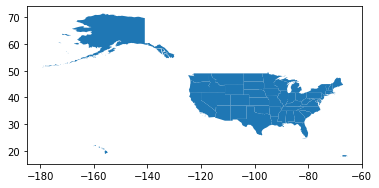

In [18]:
map_df.plot()
plt.xlim(-185,-60)

In [20]:
# I think we need the column info to match so I'm going by state

train['state'] = train['state'].str.upper()
train['state']

1541      VT
265421    MD
11478     VA
281431    MI
498520    TX
          ..
239906    IA
200479    ID
26717     WA
110507    CA
492913    TX
Name: state, Length: 377269, dtype: object

In [30]:
# And I think the value counts is what I will want to have to map

train['state'].value_counts()

CA    38722
FL    27352
TX    22028
NY    16777
MI    16018
OH    14487
OR    12950
NC    12587
PA    12124
WI    11688
WA    11268
TN    10531
CO     9695
VA     8660
IL     8648
IA     8594
NJ     7707
MN     7681
ID     7518
MA     7518
AZ     6618
AL     6529
MT     6287
SC     6121
IN     5752
KS     5434
CT     5153
GA     5133
AR     4951
MO     4840
OK     4756
KY     4615
MD     3334
NM     3106
AK     3010
LA     2892
VT     2350
RI     2344
NV     2312
NH     2305
ME     2262
HI     2214
DC     2092
NE     2085
MS     1909
SD     1826
UT     1245
DE     1104
WY      818
WV      689
ND      630
Name: state, dtype: int64

In [42]:
states_df = train['state'].value_counts().rename_axis('state').reset_index(name='ads')
states_df

,state,ads
0,CA,38722
1,FL,27352
2,TX,22028
3,NY,16777
4,MI,16018
5,OH,14487
6,OR,12950
7,NC,12587
8,PA,12124
9,WI,11688


In [43]:
# merge geopanda with dataset on state

merged = map_df.set_index('STUSPS').join(states_df.set_index('state'))

merged.head()

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,ads
STUSPS,,,,,,,,,,
MD,24,01714934,0400000US24,24,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",3334.0
IA,19,01779785,0400000US19,19,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",8594.0
DE,10,01779781,0400000US10,10,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",1104.0
OH,39,01085497,0400000US39,39,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",14487.0
PA,42,01779798,0400000US42,42,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",12124.0


In [44]:
merged.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'ads'],
      dtype='object')

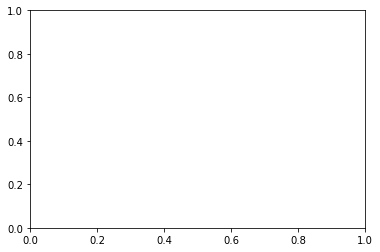

In [64]:
# prep for matplotlib
# set a variable of interest to plot

variable = 'ads'

# set ranges

vmin, vmax = 630, 39000

# fig xis size

fig, ax = plt.subplots(1,1)

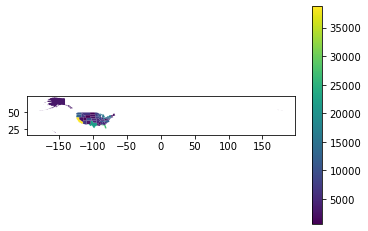

In [66]:
# create map
merged.plot(column = variable)


In [52]:
# Formatting
ax.set_title('Craigslist Ads by State', fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.annotate('Scraped in January 2020',xy=(0.1,0.08), horizontalalignment='left')

# create legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin, vmax))

#empty array for data range

sm._A = []
cbar = fig.colorbar(sm)

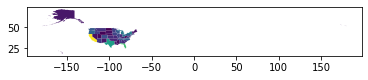

In [92]:
ax.set_adjustable('box')
ax.set_aspect('auto')
ax.set_xlim([-180, -60])
ax.set_xbound(lower=-180, upper=-60)
ax.axis('off')
merged.plot(column = variable, legend=True, linewidth = 0.8)


In [76]:
# Well screw that let's try plotly

# fig = px.choropleth(merged, geojson=counties, locations='fips', color='unemp',
#                            color_continuous_scale="Viridis",
#                            range_color=(0, 12),
#                            scope="usa",
#                            labels={'unemp':'unemployment rate'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

# okay never mind the .shp isn't made to play easily, but it would be cool later